In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals


In [2]:
!pip install imageio

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display


import tensorflow as tf


### STEP #1: IMPORT DATASETS AND NORMALIZE IT

In [4]:
# (train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()


In [5]:
train_images.shape

(60000, 28, 28)

In [6]:
train_labels.shape

(60000,)

In [7]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')


In [8]:
train_images.shape

(60000, 28, 28, 1)

In [9]:
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [10]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [11]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### STEP #2: VISUALIZE DATASET

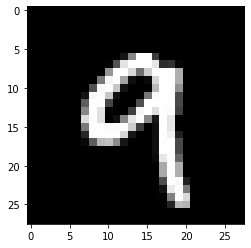

In [12]:
plt.imshow(train_images[110].reshape((28,28)) , cmap = 'gray')

### STEP #3: BUILD GENERATOR

In [13]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) # 12544
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    # Because we used "same" padding and stride = 1, the output is the same size as input 7 x 7 but with 128 filters instead
    # Resulting in 7 x 7 x 128
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Because we used "same" padding and stride = 2, the output is double the size of the input 14 x 14 but with 64 filters instead
    # Resulting in 14 x 14 x 64
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Because we used "same" padding and stride = 2, the output is double the size of the input 28 x 28 but with 1 filter instead
    # Resulting in 28 x 28 x 1
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    model.summary()

    return model

In [14]:
# Let's test it and check the dimensions
generator = make_generator_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [ ]:
# Let's test it with a random noise seed and see the output

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape

In [ ]:
plt.imshow(generated_image[0,:,:,0], cmap='gray')

### STEP#4: BUILD THE DISCRIMINATOR

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    model.summary()

    return model

In [ ]:
# Let's see the model structure
discriminator = make_discriminator_model()

In [ ]:
# Give it a shot and see if the discriminator was able to classify the image or not! 
# The model will be trained to output positive values for real images, and negative values for fake images.
decision = discriminator(generated_image)
print (decision)

### STEP #5: DEFINE THE LOSS FUNCTIONS FOR BOTH NETWORKS

In [ ]:
# This computes the 'loss' which simply the difference between the model predictions and the true label
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
# The discriminator loss indicates how well the discriminator is able to distinguish real and fake images. 
# It compares the discriminator's predictions on real images to an array of 1s, 
# and the discriminator's predictions on fake (generated) images to an array of 0s.

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss # sum up both losses
    return total_loss

In [ ]:
# The generator's loss quantifies how well it was able to trick the discriminator. 
# if the generator is performing well, the discriminator will classify the fake images as real (or 1). 
# Here, we will compare the discriminators decisions on the generated images to an array of 1s.

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### STEP#6: TRAIN THE MODEL

In [ ]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True) # step 1. call the generator and feed in the noise seed

      real_output = discriminator(images, training=True) # step 2. pass the fake and real ones to discriminator to perform classification
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output) # step 3. Calculate the loss for both the generator and discriminator
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # step 4. calculate the gradient of the losses
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # step 5. Apply the optimizers and update weights
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

#### EXECUTE FASHION_MNIST

In [ ]:
%%time
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)